In [ ]:
import xml.etree.ElementTree as ET
from operator import itemgetter

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Masking
from keras.callbacks import History
from keras.utils.vis_utils import model_to_dot

import numpy as np
import numpy.random
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import SVG

from tqdm import tqdm

import sananmuunnin as sm
from one_hot import *

plt.style.use('seaborn-darkgrid')

In [2]:
KOTUS_WORD_LIST = "./kotus/kotus-sanalista_v1.xml"
MODEL_PATH = "sananmuunnin.h5"

HIDDEN_SIZE = 60
BATCH_SIZE = 128
EPOCHS = 20

DATA_SIZE = 400000
VAL_SPLIT = 0.2

In [3]:
def read_kotus_words(filename, characters, max_length):
    return [
        s.text for s in ET.parse(filename).iterfind("st/s")
        if all(char in characters for char in s.text) and len(s.text) <= max_length
    ]

words = read_kotus_words(KOTUS_WORD_LIST, CHARACTERS, 15)
words[:5]

['aakkonen',
 'aakkosellinen',
 'aakkosellisesti',
 'aakkosellisuus',
 'aakkosittain']

In [4]:
def generate_data(words, one_hot_encoder, size):
    word_indices = np.random.randint(0, len(words), (size, 2))
 
    max_len = max(len(word) for word in words) * 2 + 3
    encoder_inputs = np.empty((DATA_SIZE, max_len, N_CHARACTERS))
    decoder_inputs = np.empty((DATA_SIZE, max_len, N_CHARACTERS))
    decoder_targets = np.empty((DATA_SIZE, max_len, N_CHARACTERS))
    
    for i, pair_indices in tqdm(enumerate(word_indices), total=size):
        input_words = itemgetter(*pair_indices)(words)
        output_words = sm.transform(*input_words)

        encoder_input = one_hot_encoder.encode(" ".join(input_words), max_len)
        decoder_input = one_hot_encoder.encode(START_TOKEN + " ".join(output_words) + END_TOKEN, max_len)
        decoder_target = np.roll(decoder_input, -1, axis=0)
        decoder_target[-1, :] = 0

        encoder_inputs[i] = encoder_input
        decoder_inputs[i] = decoder_input
        decoder_targets[i] = decoder_target
        
    return encoder_inputs, decoder_inputs, decoder_targets

one_hot_encoder = OneHot()
encoder_input, decoder_input, decoder_target = generate_data(words, one_hot_encoder, DATA_SIZE)
encoder_input.shape, decoder_input.shape, decoder_target.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [01:40<00:00, 3968.07it/s]


((400000, 33, 32), (400000, 33, 32), (400000, 33, 32))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None, 32)     0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 32)     0                                            
__________________________________________________________________________________________________
encoder_input_mask (Masking)    (None, None, 32)     0           encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input_mask (Masking)    (None, None, 32)     0           decoder_input[0][0]              
__________________________________________________________________________________________________
encoder_ls

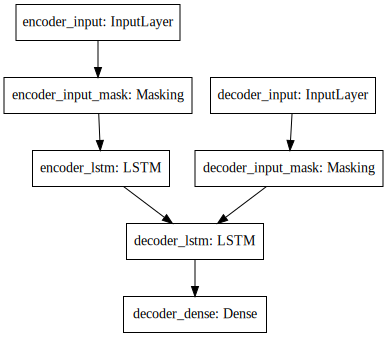

In [5]:
encoder_inputs = Input(shape=(None, N_CHARACTERS), name="encoder_input")
encoder_lstm = LSTM(HIDDEN_SIZE, return_state=True, name="encoder_lstm")
encoder_input_mask = Masking(name="encoder_input_mask")
encoder_outputs, state_h, state_c = encoder_lstm(encoder_input_mask(encoder_inputs))
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, N_CHARACTERS), name="decoder_input")
decoder_lstm = LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_input_mask = Masking(name="decoder_input_mask")
decoder_outputs, _, _ = decoder_lstm(decoder_input_mask(decoder_inputs), initial_state=encoder_states)
decoder_dense = Dense(N_CHARACTERS, activation="softmax", name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()
SVG(model_to_dot(model).create(prog="dot", format="svg"))

In [6]:
history = model.fit(
    [encoder_input, decoder_input],
    decoder_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VAL_SPLIT,
    verbose=2,
    callbacks=[History()],
)

Train on 320000 samples, validate on 80000 samples
Epoch 1/20
 - 501s - loss: 2.0529 - acc: 0.3050 - val_loss: 1.6996 - val_acc: 0.4056
Epoch 2/20
 - 465s - loss: 1.5183 - acc: 0.4604 - val_loss: 1.3477 - val_acc: 0.5142
Epoch 3/20
 - 412s - loss: 1.2242 - acc: 0.5521 - val_loss: 1.0727 - val_acc: 0.6004
Epoch 4/20
 - 463s - loss: 0.9944 - acc: 0.6271 - val_loss: 0.8820 - val_acc: 0.6638
Epoch 5/20
 - 442s - loss: 0.8216 - acc: 0.6844 - val_loss: 0.7419 - val_acc: 0.7102
Epoch 6/20
 - 471s - loss: 0.6879 - acc: 0.7285 - val_loss: 0.6222 - val_acc: 0.7495
Epoch 7/20
 - 432s - loss: 0.5873 - acc: 0.7618 - val_loss: 0.5407 - val_acc: 0.7772
Epoch 8/20
 - 490s - loss: 0.5119 - acc: 0.7869 - val_loss: 0.4682 - val_acc: 0.8030
Epoch 9/20
 - 453s - loss: 0.4525 - acc: 0.8068 - val_loss: 0.4255 - val_acc: 0.8155
Epoch 10/20
 - 414s - loss: 0.4047 - acc: 0.8229 - val_loss: 0.3859 - val_acc: 0.8297
Epoch 11/20
 - 469s - loss: 0.3658 - acc: 0.8362 - val_loss: 0.3650 - val_acc: 0.8365
Epoch 12/20


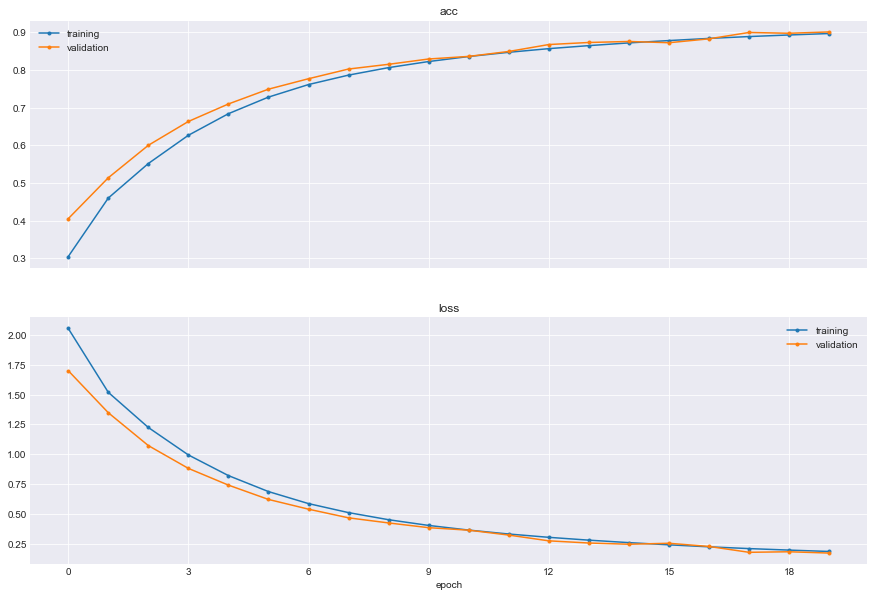

In [7]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

for ax, value in zip(axes, ("acc", "loss")):
    ax.plot(history.history[value], 'o-', ms=3, label="training")
    ax.plot(history.history[f"val_{value}"], 'o-', ms=3, label="validation")
    ax.set_title(value)
    ax.legend()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("epoch");

In [8]:
model.save(MODEL_PATH)

c:\users\con_jmerilai\appdata\local\continuum\anaconda3\lib\site-packages\keras\engine\network.py:888: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm/while/Exit_2:0' shape=(?, 60) dtype=float32>, <tf.Tensor 'encoder_lstm/while/Exit_3:0' shape=(?, 60) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
